In [1]:
# Running on GPU?
import setGPU

setGPU: Setting GPU to: 0


# Drift Tubes Digi Occupancy Anomaly Problem

* [Load data](#Load-occupancy-data-to-the-dataframe)
* [Preprocessing](#Preprocessing)
    * [Visualize preprocessing](#Visualize-preprocessing-steps)
* [Anomaly detection](#Supervised-searching-for-anomalies)
    * [Production baseline](#Production-baseline)
    * [Dataset split](#Split-the-dataset-to-be-able-to-use-supervised-learning)
    * [Simple statistics](#Baseline-simple-alternative-tests)
    * [One Class SVM & Isolation Forst](#Benchmarking-SVM-and-IF)
    * [Neural Networks](#Train-and-test-Neural-Networks)

In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

Using TensorFlow backend.


In [3]:
# Set a random seed to reproduce the results

rng = np.random.RandomState(0)

In [4]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [5]:
#Define those yourself if you want to use your own data

#data_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"
#labels_directory = "/eos/cms/store/cmst3/group/dehep/adpol/dt/data"

data_directory = "../data"
labels_directory = "../data"

## Load occupancy data to the dataframe

In [6]:
# Load occupancy data to the dataframe

runs = [272011, 272012, 272014, 272017, 272021, 272774, 273158, 273730,
        274388, 274422, 274968, 274969, 275310, 275311, 275847, 275890,
        276244, 276283, 276384, 276582, 276587, 276775, 276776, 276950,
        278509, 278820, 278822, 279694, 279766, 279794, 280018, 281693,
        281727, 281976, 282735, 282814, 284041, 284042, 284043, 284044,
        297411, 297467, 297468, 297469, 297484, 297665, 297666, 297678,
        299000, 300087, 300390, 300391, 300392, 300393, 300395, 300396,
        300397, 300398, 300399, 300497, 300558, 301142, 301383, 301384,
        302031, 302038, 302040, 302041, 302042, 302043, 302350, 302548,
        302634, 302635, 304144, 304737, 304738, 304739, 304740, 305064,
        305081, 306041, 306042, 306049]

test_run = [302634, 302635, 304737, 304738, 304739, 304740]
train_runs = [r for r in runs if r not in test_run]

drift_tubes_layers = pd.DataFrame()
for run in runs:
    print("Loading %s" % run, end="\r")
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);
print("Done. Collected %s layers" % drift_tubes_layers.shape[0], end="\r")

In [7]:
# Transform the string to list

drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(np.array)

In [8]:
# Append score from labels data file

labels_frame = pd.read_csv(("%s/labels.csv" % labels_directory),
                           names=["wheel", "station", "sector", "run", "layer", "score"])

def apply_score(layer):
    """Applies scores form label file"""
    score = labels_frame[(labels_frame.wheel == layer.wheel) &
                         (labels_frame.station == layer.station) &
                         (labels_frame.sector == layer.sector) &
                         (labels_frame.run == layer.run) &
                         (labels_frame.layer == layer.layer)].score.values
    if not len(score):
        return np.nan

    return score[0]

drift_tubes_layers["score"] = drift_tubes_layers.apply(apply_score, axis=1);

## Preprocessing

In [9]:
# Use median polling to remove channels with extreme values

SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

In [10]:
print("Minimum raw length: % s" % min(drift_tubes_layers["content"].apply(len)))
print("Maximum raw length: % s" % max(drift_tubes_layers["content"].apply(len)))
print("Minimum smoothed length: % s" % min(drift_tubes_layers["content_smoothed"].apply(len)))
print("Maximum smoothed length: % s" % max(drift_tubes_layers["content_smoothed"].apply(len)))

Minimum raw length: 47
Maximum raw length: 96
Minimum smoothed length: 45
Maximum smoothed length: 94


In [11]:
# Use bilinear interpolation to resize all the data samples

def resize_occupancy(layer):
    """Resizes occupancy to a given size using bilinear interpolation"""
    return misc.imresize(np.array(layer).reshape(1, -1), (1, SAMPLE_SIZE), interp="bilinear", mode="F").reshape(-1)

SAMPLE_SIZE = min(drift_tubes_layers["content"].apply(len))
drift_tubes_layers["content_resized"] = drift_tubes_layers["content"].apply(resize_occupancy)

SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))
drift_tubes_layers["content_smoothed_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

In [12]:
# Scale the data

def scale_occupancy(layer):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

drift_tubes_layers["content_scaled"] = drift_tubes_layers["content_resized"].apply(scale_occupancy)
drift_tubes_layers["content_smoothed_scaled"] = drift_tubes_layers["content_smoothed_resized"].apply(scale_occupancy)

### Visualize preprocessing steps

Combine per layer data to per chamber data (this is used only for the visualization section):

In [13]:
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 5):
            for sector in range(1, 15):
                if labels_frame[(labels_frame.run == run) &
                                (labels_frame.wheel == wheel) &
                                (labels_frame.station == station) &
                                (labels_frame.sector == sector)].empty:
                    continue

                chamber = drift_tubes_layers[(drift_tubes_layers.run == run) &
                                             (drift_tubes_layers.wheel == wheel) &
                                             (drift_tubes_layers.station == station) &
                                             (drift_tubes_layers.sector == sector)].sort_values("layer",
                                                                                                ascending=1)
                if not len(chamber):
                    continue
                
                occupancy_raw = [layer.tolist() for layer in chamber["content"]]
                occupancy_smoothed = [layer.tolist() for layer in chamber["content_smoothed"]]

                occupancy_resized = np.concatenate(
                    chamber["content_resized"].values).reshape(-1, 47)
                occupancy_scaled = np.concatenate(
                    chamber["content_scaled"].values).reshape(-1, 47)
                occupancy_smoothed_resized = np.concatenate(
                    chamber["content_smoothed_resized"].values).reshape(-1, 45)
                occupancy_smoothed_scaled = np.concatenate(
                    chamber["content_smoothed_scaled"].values).reshape(-1, 45)

                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))
                extended_size_raw = max((len(_) for _ in occupancy_raw))
                
                for index, layer in enumerate(occupancy_raw):
                    layer.extend([np.nan]*(extended_size_raw-len(layer)))
                    occupancy_raw[index] = layer

                for index, layer in enumerate(occupancy_smoothed):
                    layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                    occupancy_smoothed[index] = layer

                score = sum(chamber.score.values)
                
                data = {"run": run,
                        "wheel": wheel,
                        "station": station,
                        "sector": sector,
                        "score": score,
                        "content_raw": np.concatenate(
                            occupancy_raw).reshape(len(chamber), extended_size_raw),
                        "content_smoothed": np.concatenate(
                            occupancy_smoothed).reshape(len(chamber), extended_size_smoothed),
                        "content_resized": occupancy_resized,
                        "content_smoothed_resized": occupancy_smoothed_resized,
                        "content_scaled": occupancy_scaled,
                        "content_smoothed_scaled": occupancy_smoothed_scaled}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data),
                                                                   ignore_index=True)

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_occupancy_hitmap(data, title):
    """Visualizes occupancy hitmap"""
    plt.figure()
    
    ax = plt.gca()
    
    ax.set_yticklabels(["1", "5", "9"])
    ax.set_yticks([0, 4, 8])
    plt.xlabel("Channel")
    plt.ylabel("Layer")
    
    im = ax.imshow(data, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(data)), np.max(np.nan_to_num(data))])
    plt.title(title, loc="right")   
    plt.show();
    
def get_title(title, show):
    """Generates title for occupancy plot"""
    return ("%s Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show, smoothed):
    """Visualizes preprocessing steps"""
    if smoothed:
        plot_occupancy_hitmap(show.content_smoothed, get_title("Smoothed", show))
        plot_occupancy_hitmap(show.content_smoothed_resized, get_title("Standardized", show))
        plot_occupancy_hitmap(show.content_smoothed_scaled, get_title("Scaled", show)) 

    else:
        plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))
        plot_occupancy_hitmap(show.content_resized, get_title("Standardized", show))
        plot_occupancy_hitmap(show.content_scaled, get_title("Scaled", show))

Example of preprocessing pipeline for <b>chamber without problems</b>:

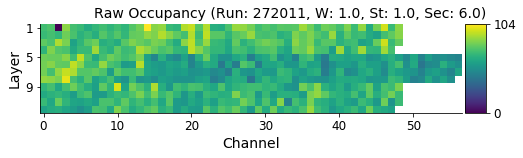

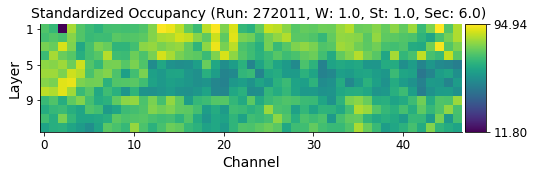

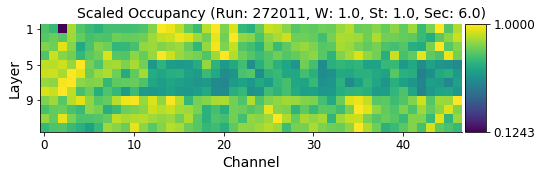

In [15]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], False)

Example of preprocessing pipeline for <b>chamber with one faulty layer</b>:

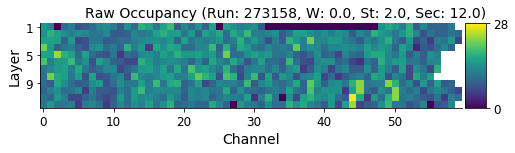

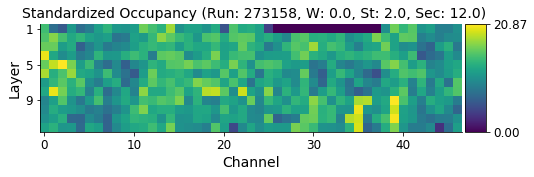

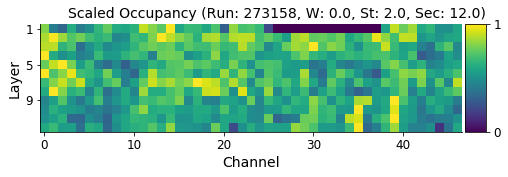

In [16]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 11].iloc[0], False)

Example of preprocessing pipeline for <b>chamber with twelve faulty layer</b>:

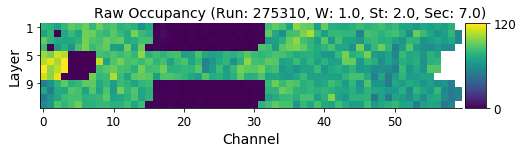

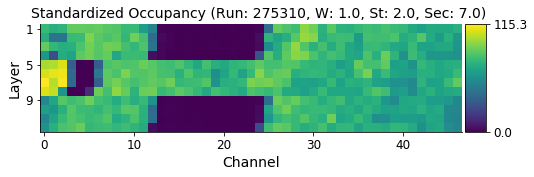

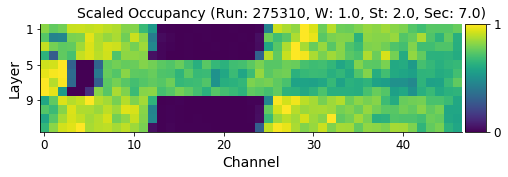

In [17]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[3], False)

Example of <b>alternative</b> preprocessing (with median polling) pipeline for <b>chamber without problems</b>:

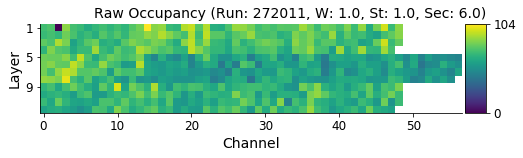

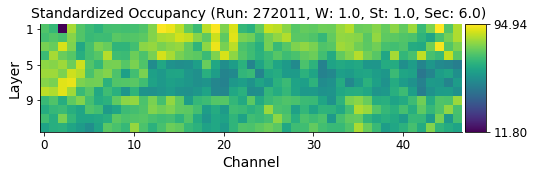

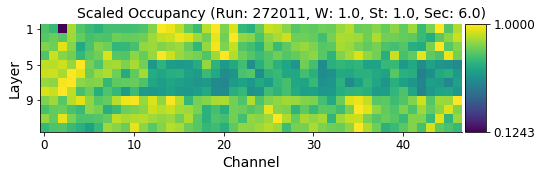

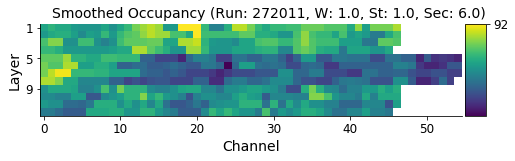

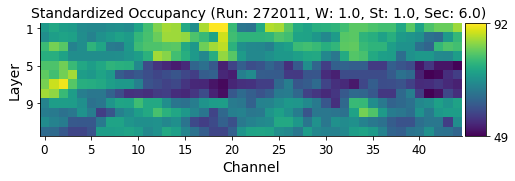

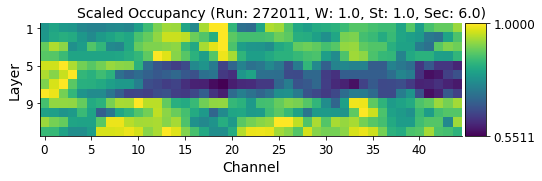

In [18]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], False)
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6], True)

## Supervised searching for anomalies

In [19]:
lines = [(color_palette["Orange"][900], line_styles[0]),
         (color_palette["Indigo"][200], line_styles[0]),
         (color_palette["Indigo"][900], line_styles[0]),
         (color_palette["Indigo"][400], line_styles[0]),
         (color_palette["Indigo"][400], line_styles[1]),
         (color_palette["Indigo"][900], line_styles[1]),
         (color_palette["Indigo"][200], line_styles[1])]

In [20]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
  
    for i, (legend_label, model_score) in enumerate(models):
        fpr, tpr, _ = roc_curve(test_df["score"], test_df[model_score])
        auc_v = round(auc(fpr, tpr), 3)
        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 color=lines[i][0],
                 linestyle=lines[i][1],
                 label=("%s, AUC: %s" % (legend_label, auc_v)))
        
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 "o",
                 color="#80CBC4",
                 markersize=10,
                 label="CNN working point")

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.xlim(0, 0.25)
    plt.show();

In [21]:
def benchmark(y_true, y_pred):
    """Retrun TPR and FPR"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()   
    sensitivity = float(tp)/(tp+fn)
    specificity = float(tn)/(tn+fp)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 2))
    print("Model sensitivity: %s" % round(sensitivity, 2))
    print("Model specificity: %s" % round(specificity, 2))
    
    return specificity, sensitivity

### Production baseline

In [22]:
def production_test(content):
    """Calculate score that mirrors the test currently in production"""
    return (float(len(np.where(content == 0)[0])) / len(np.where(~np.isnan(content))[0]))

drift_tubes_chambers["treshold"] = drift_tubes_chambers["content_raw"].apply(production_test)
benchmark(drift_tubes_chambers["score"] < 12, drift_tubes_chambers["treshold"] > 0.1);

Model accuracy: 0.63
Model sensitivity: 0.26
Model specificity: 0.91


In [23]:
print("Chamber without problems: %s" % drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[6]["treshold"])
print("Chamber with one faulty layer: %s" % drift_tubes_chambers[drift_tubes_chambers.score == 11].iloc[0]["treshold"])
print("Chamber with twelve faulty layers: %s" % drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[3]["treshold"])

Chamber without problems: 0.00162074554295
Chamber with one faulty layer: 0.0298719772404
Chamber with twelve faulty layers: 0.142247510669


### Split the dataset to be able to use supervised learning

In [24]:
def change_score(score):
    return -(2*score-1)

drift_tubes_layers['score'] = drift_tubes_layers['score'].apply(change_score)

drift_tubes_layers_scored = drift_tubes_layers[~np.isnan(drift_tubes_layers.score)]

anomalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == 1]
normalies = drift_tubes_layers_scored[drift_tubes_layers_scored.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

print("Number of anomalies in the train set: %s" % len(anomalies_test))
print("Number of normal in the train set: %s" % len(normalies_test))

612 faults and 5668 good samples. In total: 6280.
Number of anomalies in the train set: 123
Number of normal in the train set: 1134


### Baseline simple alternative tests

In [25]:
def sobel(content):
    return max(abs(ndimage.sobel(content)[0]))

def variance(content):
    return np.var(content)
    
layers_test["sobel_score"] = layers_test["content_smoothed_scaled"].apply(sobel)
layers_test["variance_score"] = layers_test["content_smoothed_scaled"].apply(variance)

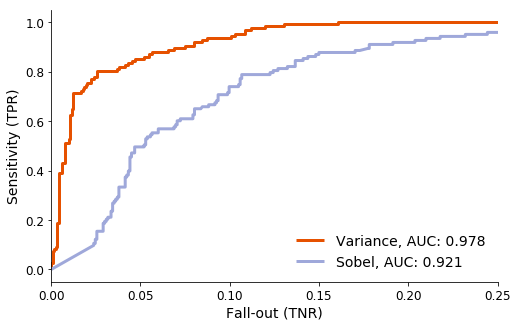

In [26]:
get_roc_curve(layers_test, [("Variance", "variance_score"),
                            ("Sobel", "sobel_score")])

### Benchmarking SVM and IF

Cross validate model selection using Stratified5Fold and GridSearchCV:

In [27]:
def cross_validation_spit(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [28]:
# This may take some time...

param_grid = [{"nu": np.array(range(1, 10, 1))/10.0,
               "gamma": ["auto", 0.1, 0.01, 0.001, 0.0001],
               "kernel": ["linear", "rbf"]}]

svmparams = cross_validation_spit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                                  -layers_train["score"],
                                  svm.OneClassSVM(random_state=rng),
                                  param_grid)

print(svmparams)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.40000000000000002,
      random_state=<mtrand.RandomState object at 0x7fdac5b26d80>,
      shrinking=True, tol=0.001, verbose=False)


In [29]:
# Retrain SVM using only good samples

svmclf = svm.OneClassSVM(nu=svmparams.nu,
                         gamma=svmparams.gamma,
                         kernel=svmparams.kernel,
                         random_state=rng)
svmclf.fit(np.concatenate(normalies_train["content_smoothed_scaled"].values));

In [30]:
# This may take some time...

param_grid = [{"max_samples": [100, 1000],
               "n_estimators": [10, 100],
               "contamination": np.array(range(4, 13, 1))/100.0}]

ifparams = cross_validation_spit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                                 -layers_train["score"],
                                 IsolationForest(random_state=rng),
                                 param_grid)

print(ifparams)

IsolationForest(bootstrap=False, contamination=0.040000000000000001,
        max_features=1.0, max_samples=1000, n_estimators=100, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x7fdac5896678>,
        verbose=0)


In [31]:
# Retrain IF using all unlabelled samples

ifclf = IsolationForest(max_samples=ifparams.max_samples,
                        n_estimators=ifparams.n_estimators,
                        contamination=ifparams.contamination,
                        random_state=rng)

ifclf.fit(np.concatenate(drift_tubes_layers[np.isnan(drift_tubes_layers.score)]["content_smoothed_scaled"].values));

In [32]:
from sklearn import tree

bdtclf = tree.DecisionTreeClassifier(class_weight="balanced", random_state=rng)
bdtclf = bdtclf.fit(np.concatenate(layers_train["content_smoothed_scaled"].values),
                    layers_train["score"])

print(bdtclf.get_params())

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_split': 1e-07, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': <mtrand.RandomState object at 0x7fdad3a16168>, 'splitter': 'best'}


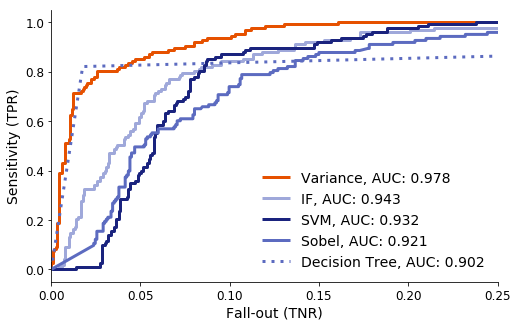

In [33]:
layers_test["svm_score"] = -svmclf.decision_function(np.concatenate(layers_test["content_smoothed_scaled"].values))
layers_test["if_score"] = -ifclf.decision_function(np.concatenate(layers_test["content_smoothed_scaled"].values))
layers_test["bdt_score"] = bdtclf.predict_proba(
    np.array(np.concatenate(layers_test["content_smoothed_scaled"].values)))[:,1]

get_roc_curve(layers_test,[("Variance", "variance_score"),                           
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("Sobel", "sobel_score"),
                           ("Decision Tree", "bdt_score")])

### Train and test Neural Networks

In [34]:
# Start Keras session:

sess = tf.Session()
K.set_session(sess)

In [35]:
# Generate CNN input

def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0])
    return np.asarray([0, 1])

def generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 47),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 47),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 47))

(train_x, train_y, val_x, val_y, test_x) = generate_input()

Due to imbalanced classes model requires different penalization of the misclassification. Calculate weights for different classes:

In [36]:
cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}

In [37]:
# Define networks

def shallow_neural_network():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name="input_snn"))
    model.add(Flatten(name="flatten_snn"))
    model.add(Dense(8, name="dense_snn", activation="relu"))
    model.add(Dense(2, activation="softmax", name="output_snn"))
    return model

def convolutional_neural_network():
    model = Sequential()
    model.add(Reshape((47, 1), input_shape=(47,), name="input_cnn"))
    model.add(Conv1D(10, 3, strides=1, padding="valid", name="convolution_cnn", activation="relu"))
    model.add(MaxPooling1D(pool_size=5, strides=5, padding="valid", name="polling_cnn"))
    model.add(Flatten(name="flatten_cnn"))
    model.add(Dense(8, name="dense_cnn", activation="relu"))
    model.add(Dense(2, activation="softmax", name="output_cnn"))
    return model

snn = shallow_neural_network()
cnn = convolutional_neural_network()
print("Shallow Neural Network Architecture:")
snn.summary()
print("Convolutional Network Architecture:")
cnn.summary()

Shallow Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_snn (Reshape)          (None, 47, 1)             0         
_________________________________________________________________
flatten_snn (Flatten)        (None, 47)                0         
_________________________________________________________________
dense_snn (Dense)            (None, 8)                 384       
_________________________________________________________________
output_snn (Dense)           (None, 2)                 18        
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________
Convolutional Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_cnn (Reshape)          (None, 47, 1)             0         
_____

Train neural networks:

In [38]:
def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer="adam")

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("../model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [49]:
history_snn = train_nn(snn,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "snn",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 02162: early stopping


In [40]:
history_cnn = train_nn(cnn,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "cnn",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 01452: early stopping


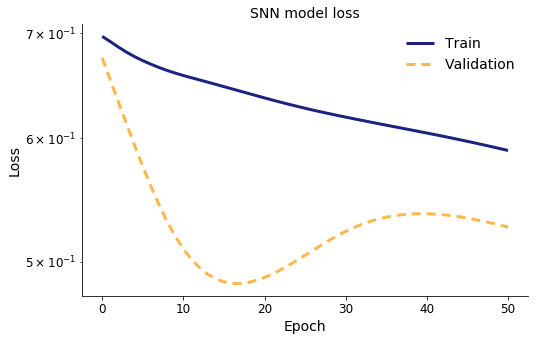

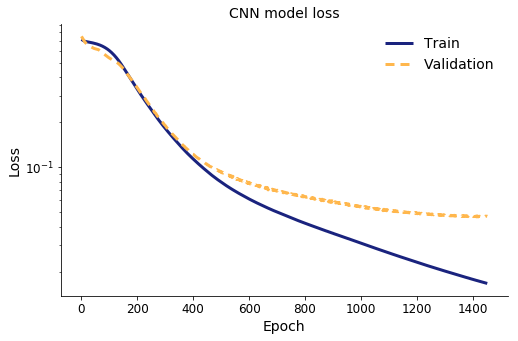

In [41]:
# Plot loss vs. epoch

def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

plot_loss(history_snn.history, "SNN model loss")
plot_loss(history_cnn.history, "CNN model loss")

In [42]:
# Export models as .pb, needed for CMSSW implementation:

# outputs = [cnn.output.name.split(":")[0]]
# print("Input name: %s" % cnn.inputs[0].name.split(":")[0])
# print("Output name: %s" % outputs[0])
# constant_graph = tf.graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), outputs);
# tf.train.write_graph(constant_graph, "../model-new", "constantgraph.pb", as_text=False);

In [43]:
# Reload models from saved

snn_model = load_model("../model_keras/snn.h5")
cnn_model = load_model("../model_keras/cnn.h5")

In [44]:
# Calculate score for trained networks:

layers_test["snn_score"] = snn_model.predict(np.array(test_x))[:, 1]
layers_test["cnn_score"] = cnn_model.predict(np.array(test_x))[:, 1]

In [45]:
specificity, sensitivity = benchmark(layers_test["score"] == 1, layers_test["cnn_score"] > 0.5)

Model accuracy: 0.99
Model sensitivity: 0.97
Model specificity: 0.99


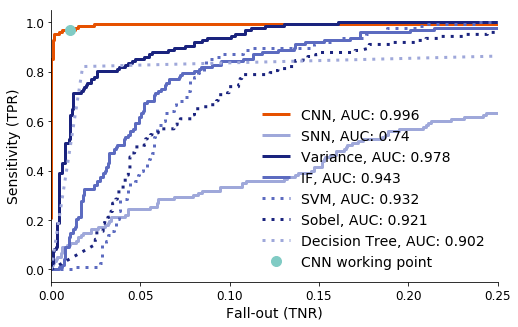

In [46]:
get_roc_curve(layers_test,
              [("CNN", "cnn_score"),
               ("SNN", "snn_score"),
               ("Variance", "variance_score"),
               ("IF", "if_score"),
               ("SVM", "svm_score"),
               ("Sobel", "sobel_score"),
               ("Decision Tree", "bdt_score")],
              (specificity, sensitivity))

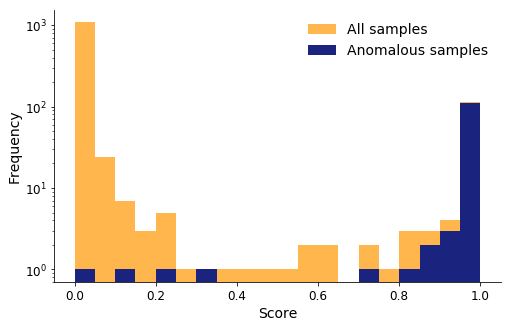

In [47]:
filter = layers_test["score"] == 1

plt.hist(layers_test["cnn_score"],
         label = "All samples",
         color = color_palette["Orange"][300],
         bins= np.arange(0, 1.05, 0.05))

plt.hist(layers_test["cnn_score"][filter],
         label = "Anomalous samples",
         color = color_palette["Indigo"][900],
         bins=np.arange(0, 1.05, 0.05))

plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show();

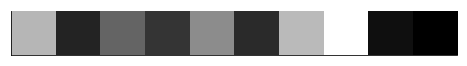

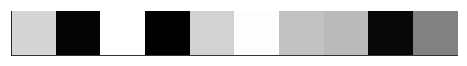

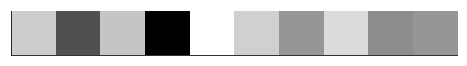

In [48]:
# Show convolutional filters

for layer_filter in cnn_model.layers[1].get_weights()[0]:
    plt.imshow(layer_filter, cmap="Greys", interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()